In [22]:
import pandas as pd
import os
import json
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

In [23]:
data = "output/timeQueries/influx/"
names = os.listdir(os.path.join(data))
runs = list(np.sort(os.listdir(os.path.join(data, names[0]))))
results = ["ttiResults", "rawResults", "m4Results"]

In [24]:
results_paths = [os.path.join(data, name, run, result) for result in results for run in runs for name in names ]
results_paths

['output/timeQueries/influx/intel_lab_exp/run_0/ttiResults',
 'output/timeQueries/influx/intel_lab_exp/run_0/rawResults',
 'output/timeQueries/influx/intel_lab_exp/run_0/m4Results']

In [25]:
dct = {
    'IO Count': 'mean',
    'Time (sec)': 'mean',
    'Memory': 'mean',
    'query #': 'mean',
    'width' : 'mean',
    'height' : 'mean',
    'timeRange': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'Results size': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'Error': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'dataset': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'operation': lambda col: col.mode() if col.nunique() == 1 else np.nan
}

dfs_all = [pd.read_csv(os.path.join(df, "results.csv")) for df in results_paths]
dfs = []
for i in range(0, len(dfs_all), len(runs)):
    dds = dfs_all[i : i + len(runs)]
    d = dds[0]
    if(len(runs) > 1):
        for i in range(1, len(runs)):
            d = pd.concat((d, dfs_all[i]))
        d = d.groupby(d.index).agg(**{k: (k, v) for k, v in dct.items()})
    dfs.append(d)

In [26]:
def plot_time(dfs, name):
    plt.clf()
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={'width_ratios': [3, 3, 1]})
    fig.suptitle(f"Time, IO and average time in {name} dataset")
    axs[0].plot(dfs[0]["Time (sec)"], label= "VS Cache")
    axs[0].plot(dfs[1]["Time (sec)"], label="RAW Cache")
    axs[0].plot(dfs[2]["Time (sec)"], label="Μ4")
        
    axs[1].plot(dfs[0]["IO Count"], label= "VS Cache")
    axs[1].plot(dfs[1]["IO Count"], label= "RAW Cache")

    axs[2].bar(0, dfs[0]["Time (sec)"].mean())
    axs[2].bar(1, dfs[1]["Time (sec)"].mean())
    axs[2].bar(2, dfs[2]["Time (sec)"].mean())
    axs[2].set_xticklabels([])
    
    fig.legend(loc=2, bbox_to_anchor=(0.9, 0.6), labels=["VS CACHE", "RAW Cache", "Μ4"])
    plt.show()


def plot_memory(dfs, name):
    plt.clf()
    fig, axs = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={'width_ratios': [3, 1]})
    fig.suptitle(f"Memory and average memory in {name} dataset")
    i = 0
    axs[0].plot(dfs[0]["Memory"], label= "VS Cache")
    axs[0].plot(dfs[1]["Memory"], label="RAW Cache")

    axs[1].bar(0, dfs[0]["Memory"].mean())
    axs[1].bar(1, dfs[1]["Memory"].mean())
    axs[1].set_xticklabels([])
    i+=1
    fig.legend(loc=2, bbox_to_anchor=(0.9, 0.6), labels=["VS Cache", "RAW Cache"])
    plt.show()
    
def plot_compaction(dfs, name):
    plt.clf()
    fig, axs = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [3, 1]})
    fig.suptitle(f"Data Compaction in {name} dataset")
    i = 0
    dfs[0]["TTI compaction"] = dfs[0]["Results size"]/dfs[1]["Results size"]
    dfs[2]["InfluxDB compaction"] = dfs[2]["Results size"]/dfs[1]["Results size"]

    axs[0].plot(dfs[0]["TTI compaction"], label= "VS Cache")
    axs[0].plot(dfs[2]["InfluxDB compaction"], label="Μ4")

    axs[1].bar(0, dfs[0]["TTI compaction"].mean())
    axs[1].bar(1, dfs[2]["InfluxDB compaction"].mean())
    axs[1].set_xticklabels([])
    i+= 1
    fig.legend(loc=2, bbox_to_anchor=(0.9, 0.6), labels=["VS CACHE", "RAW Cache"])

    plt.show()
    
def plot_time_per_operation(dfs, name):
    plt.clf()
    width = 0.3
    i = 0
    fig, axs = plt.subplots(1, 1, figsize=(10, 8))
    fig.suptitle(f"Average time per operation in {name} dataset")

    tti = (dfs[0][["operation", "Time (sec)"]].groupby("operation").aggregate('mean'))
    raw = (dfs[1][["operation", "Time (sec)"]].groupby("operation").aggregate('mean'))
    psql = (dfs[2][["operation", "Time (sec)"]].groupby("operation").aggregate('mean'))
    r = np.arange(3)
    axs.bar(r, tti['Time (sec)'], width=width, label="VS Cache")
    axs.bar(r + width, raw['Time (sec)'],  width=width, label= "RAW Cache")
    axs.bar(r + 2*width, psql['Time (sec)'], width=width,  label = "Μ4")
    axs.set_xticks(r + width, ['PAN', 'ZI', 'ZO'])
    i+= 1
    fig.legend(loc=2, bbox_to_anchor=(0.9, 0.6), labels=["VS Cache", "RAW Cache", "Μ4"])

    plt.show()

<Figure size 640x480 with 0 Axes>

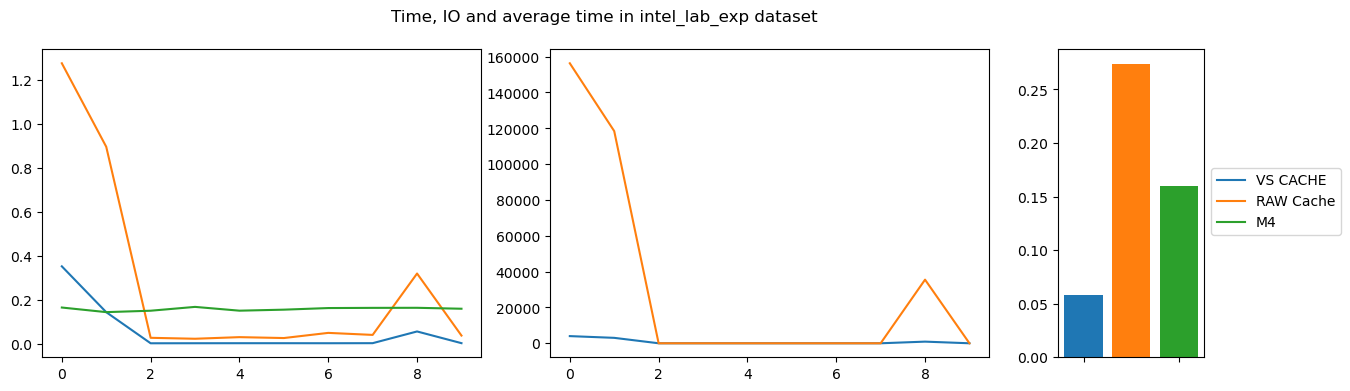

In [27]:
j = 0
for i in range(0, len(dfs), 3):
    plot_time(dfs[i : i + 3], names[i])

<Figure size 640x480 with 0 Axes>

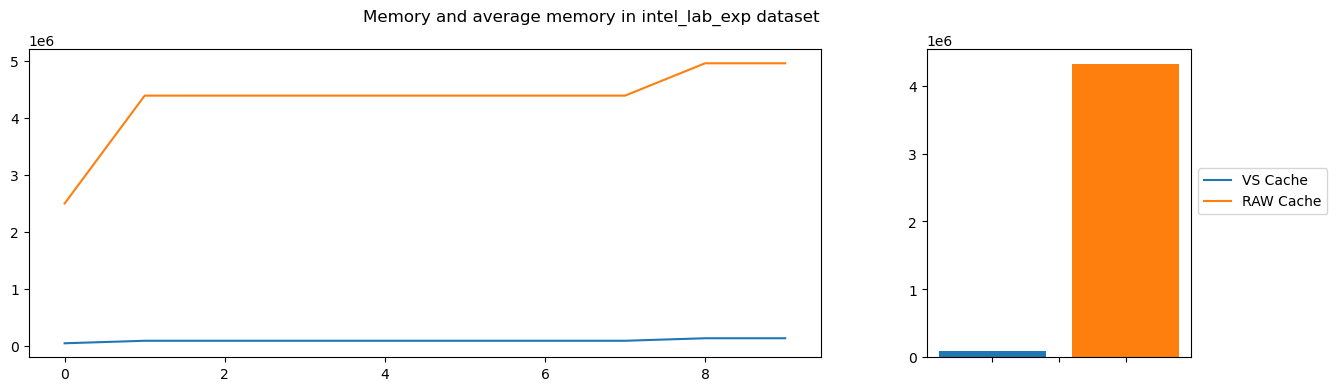

In [28]:
j = 0
for i in range(0, len(dfs), 3):
    plot_memory(dfs[i : i + 3], names[i])

<Figure size 640x480 with 0 Axes>

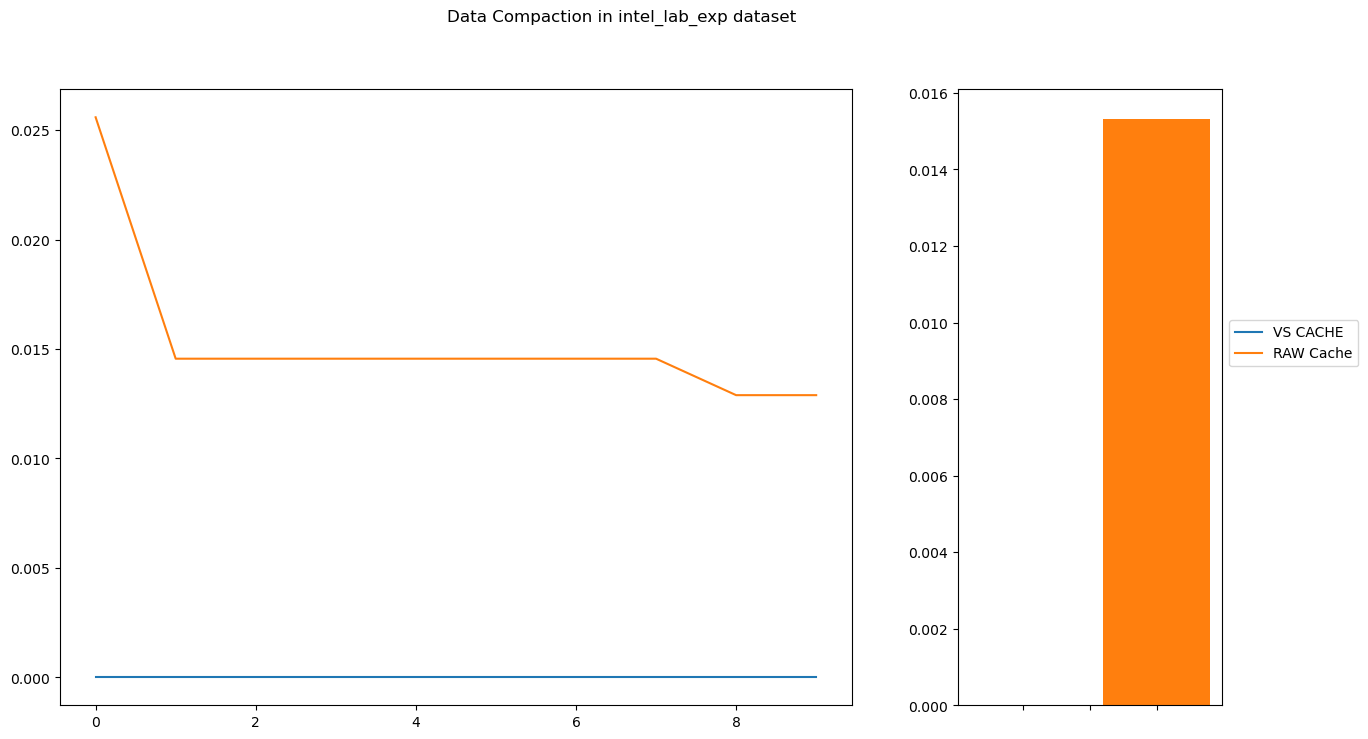

In [29]:
j = 0
for i in range(0, len(dfs), 3):
    plot_compaction(dfs[i : i + 3], names[i])

<Figure size 640x480 with 0 Axes>

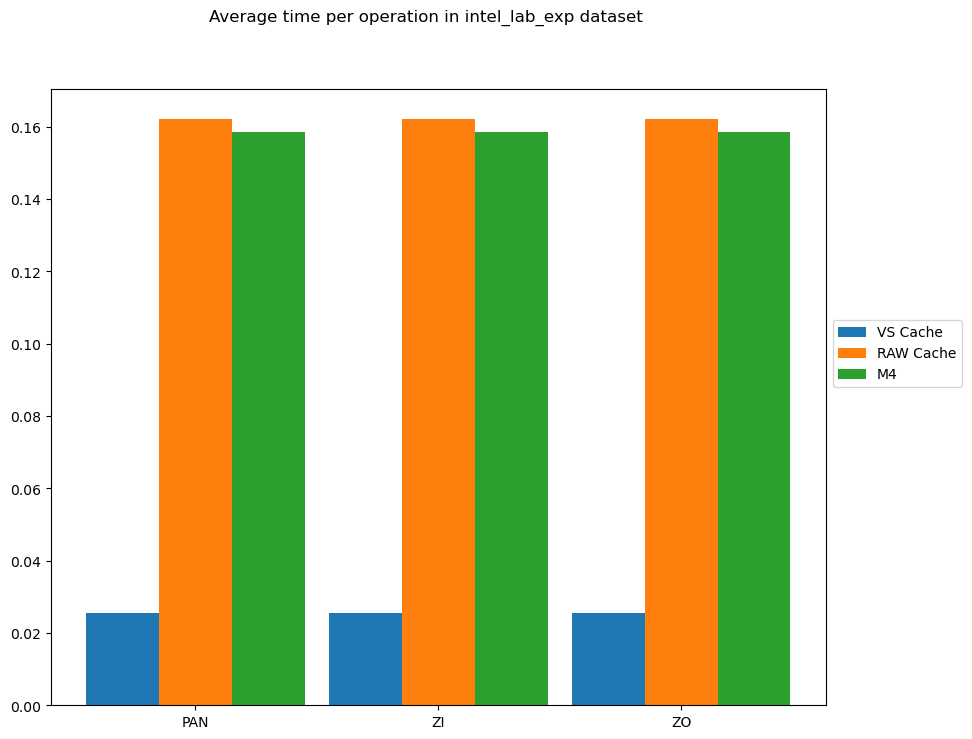

In [30]:
for i in range(0, len(dfs), 3):
    plot_time_per_operation(dfs[i : i + 3], names[i])

In [31]:
from skimage import io, color
from skimage.metrics import structural_similarity as compare_ssim

def plot(df, measure, name, width, height):
    dpi = 100
    plot_width, plot_height = width / dpi, height / dpi  # Convert from pixels to inches
    fig, ax = plt.subplots(figsize=(plot_width, plot_height))
    try:
        ax.set_xlim(df['timestamp'].min(), df['timestamp'].max())
        ax.set_ylim(df[measure].min(), df[measure].max())
    except:
        pass
    ax.axis('off')
    ax.set_position([0, 0, 1, 1])
    ax.plot(df['timestamp'], df[measure], color='black', antialiased=False)
    plt.savefig(name, transparent="True", pad_inches=0)
    plt.close()
    
    
def calculate_ssim(image_file1, image_file2, width, height):
    # Read the two images
    image1 = io.imread(image_file1)
    image2 = io.imread(image_file2)
    # Remove the alpha channel if present
    if image1.shape[2] == 4:
        image1 = image1[:, :, :3]
    if image2.shape[2] == 4:
        image2 = image2[:, :, :3]
    
    image1_gray = color.rgb2gray(image1)
    image2_gray = color.rgb2gray(image2)
    
    (score, _) = compare_ssim(image1_gray, image2_gray, full=True)
    # print(f"SSIM between {image_file1} and {image_file2}: {ssim_index:.4f}")
    diff = image1_gray - image2_gray
    # Search for all pixels that are different 
    # Type is <class 'numpy.ndarray'>, you can optionally convert to a list
    coords = np.argwhere(diff != 0)
    coords = coords.tolist() 
    return score, len(coords)/(width*height)


def get_mean_error(s, measures):
    a = (s.split("="))
    errs = []
    for l in a:
        if ("," in l):
            errs.append(float(l.split(",")[0]))
    errs.append(float(a[-1].split(",")[0][:-1]))
    return np.mean(errs)
    
    
def plot_indexes(df, name):

    fig, axs = plt.subplots(1, 1, figsize=(10, 8))

    tti_path = os.path.join(data, name, "run_0", "ttiResults")
    raw_path = os.path.join(data, name, "run_0", "rawResults")
    m4_path = os.path.join(data, name, "run_0", "rawResults")

    tti_query_0 = os.path.join(data, name, "run_0", "ttiResults", "query_0")
    sql_query_0 = os.path.join(data, name, "run_0", "m4Results", "query_0")

    meassure_files = os.listdir(tti_query_0)
    measures = [x.replace(".csv", "") for x in meassure_files]
    queries = os.listdir(results_paths[0])
    all_ssim = [] 
    all_diffs = [] 
    
    errors = df['Error'].apply(get_mean_error, args=([measures]))
    queries = [f"query_{i}" for i in range(len(df))]
    for q in queries:
        j = 0
        ssim = 0
        diffs = 0
        for m in meassure_files:
            path_tti = os.path.join(tti_path, q)
            path_raw = os.path.join(raw_path, q)
            path_sql = os.path.join(m4_path, q)
            df_tti = pd.read_csv(os.path.join(path_tti, m))
            df_raw = pd.read_csv(os.path.join(path_sql, m)) 
            width = df['width'][0]
            height = df['height'][0]
            plot(df_tti, measures[j], f"plots/{q}-{measures[j]}-tti",width,height)
            plot(df_raw, measures[j], f"plots/{q}-{measures[j]}-raw", width, height)
            score, diff = calculate_ssim(f"plots/{q}-{measures[j]}-tti.png", f"plots/{q}-{measures[j]}-raw.png", width, height)
            ssim += score
            diffs += diff
            # os.remove("tti.png")
            # os.remove("raw.png")
            j+=1  
        avg_ssim = ssim / len(measures)
        avg_diff = diffs / len(measures)
        all_ssim.append(avg_ssim)
        all_diffs.append(avg_diff)
    fig.suptitle(f"SSIM in {name} dataset.")
    axs.plot(all_ssim, label="SSIM")
    axs.plot(errors, label="MAX Error")
    axs.set_xticks([0,5,10,15,20,25,30,35,40,45,50])
    axs.plot(all_diffs, label="Difference")
    axs.legend()
    plt.show()   

In [ ]:
for i in range(0, len(dfs), 3):
    plot_indexes(dfs[i], names[i])